In [30]:
# importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.metrics import classification_report

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.calibration import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [3]:
# Importing data

train = pd.read_csv("train.txt", names = ['sentence', 'label'], sep=';').dropna()
val = pd.read_csv("val.txt", names = ['sentence', 'label'], sep=';').dropna()
test = pd.read_csv("test.txt", names = ['sentence', 'label'], sep=';').dropna()

train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
train.shape, val.shape, test.shape

((16000, 2), (2000, 2), (2000, 2))

In [5]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts()

(joy         5362
 sadness     4666
 anger       2159
 fear        1937
 love        1304
 surprise     572
 Name: label, dtype: int64,
 joy         704
 sadness     550
 anger       275
 fear        212
 love        178
 surprise     81
 Name: label, dtype: int64,
 joy         695
 sadness     581
 anger       275
 fear        224
 love        159
 surprise     66
 Name: label, dtype: int64)

<Axes: xlabel='label', ylabel='count'>

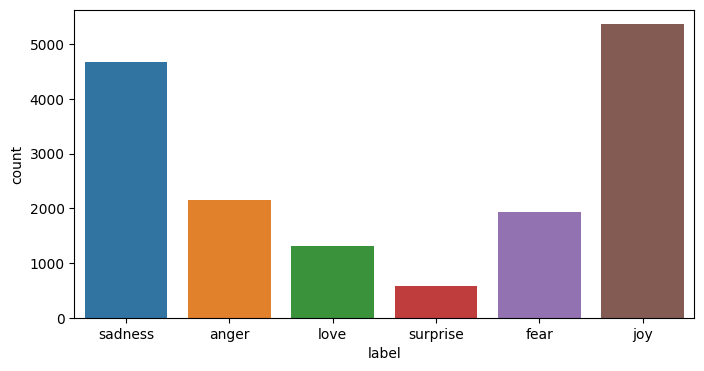

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'label', data = train)

In [7]:
# removing surprise label because its not needed and is causing class imbalance

remove_train = []
remove_val = []
remove_test = []

for i in range(len(train)):
    if train['label'][i] == 'surprise':
        remove_train.append(i)

for i in range(len(val)):
    if val['label'][i] == 'surprise':
        remove_val.append(i)

for i in range(len(test)):
    if test['label'][i] == 'surprise':
        remove_test.append(i)


remove_train = np.array(remove_train)
remove_val = np.array(remove_val)
remove_test = np.array(remove_test)

train = train.drop(remove_train)
val = val.drop(remove_val)
test = test.drop(remove_test)



In [8]:
train = train.reset_index()
val = val.reset_index()
test = test.reset_index()

train.head()

,index,sentence,label
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger


In [9]:
train = train.drop(['index'], axis = 1)
val = val.drop(['index'], axis = 1)
val = test.drop(['index'], axis = 1)

In [10]:
train.shape, val.shape, test.shape

((15428, 2), (1934, 2), (1934, 3))

In [11]:
train.label.value_counts(), val.label.value_counts(), test.label.value_counts()

(joy        5362
 sadness    4666
 anger      2159
 fear       1937
 love       1304
 Name: label, dtype: int64,
 joy        695
 sadness    581
 anger      275
 fear       224
 love       159
 Name: label, dtype: int64,
 joy        695
 sadness    581
 anger      275
 fear       224
 love       159
 Name: label, dtype: int64)

<Axes: xlabel='label', ylabel='count'>

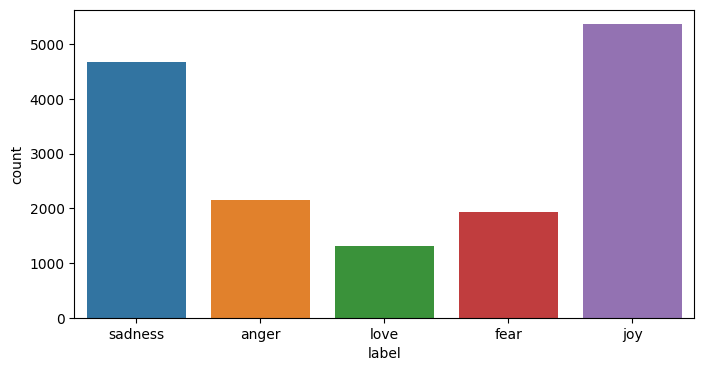

In [12]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'label', data = train)

In [13]:
train.isnull().sum(), val.isnull().sum()

(sentence    0
 label       0
 dtype: int64,
 sentence    0
 label       0
 dtype: int64)

In [14]:
train.duplicated().sum(), val.duplicated().sum()

(1, 0)

In [15]:
#removing duplicate from train dataset

duplicate = train[train.duplicated() == True]
train.drop(duplicate.index)   # removes duplicate value's index

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15423,i just had a very brief time in the beanbag an...,sadness
15424,i am now turning and i feel pathetic that i am...,sadness
15425,i feel strong and good overall,joy
15426,i feel like this was such a rude comment and i...,anger


In [16]:
# processing dataset

stop_words = set(stopwords.words("english"))

def remove_stop_words(text):
    Text = [i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    Text = ''.join([i for i in text if not i.isdigit()])
    return Text

def lower_case(text):
    Text = [i.lower() for i in str(text).split()]
    return " ".join(Text)

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    Text = [lemmatizer.lemmatize(i) for i in str(text).split()]
    return " ".join(Text)

def process_text(df):
    df.sentence = df.sentence.apply(lambda text : lower_case(text))
    df.sentence = df.sentence.apply(lambda text : remove_stop_words(text))
    df.sentence = df.sentence.apply(lambda text : Removing_numbers(text))
    df.sentence = df.sentence.apply(lambda text : lemmatization(text))
    return df

def preprocess(text):
    text = remove_stop_words(text)
    text = Removing_numbers(text)
    text = lower_case(text)
    text = lemmatization(text)
    return text

In [17]:
# using the above function 

mx = 0 
for i in range(len(train['sentence'])):
    if len(train['sentence'][i]) > len(train['sentence'][mx]):
        mx = i

print(train['sentence'][mx])  # prints the enrty with most words

train = process_text(train)
val = process_text(val)
test = process_text(test)


print(train['sentence'][mx])  # prints the same enrty but pre processed

i hope that those of you who actauly found this and read it feel possibly inspired to go out and buy some of these items or even go through storage and see what clothes of yours your mom saved and that you still have a hope of fitting in and mix up your wardrobe for this summer and have a little fun
hope actauly found read feel possibly inspired go buy item even go storage see clothes mom saved still hope fitting mix wardrobe summer little fun


In [18]:
train_x = train['sentence']
train_y = train['label']

val_x = val['sentence']
val_y = val['label']

test_x = test['sentence']
test_y = test['label']

In [19]:
#converting string categories to discrete numbers 

le = LabelEncoder()

train_y = le.fit_transform(train_y)
val_y = le.transform(val_y)
test_y = le.transform(test_y)

train_y.shape

(15428,)

In [20]:
#Convert the class vector (integers) to binary class matrix
train_y = to_categorical(train_y)
val_y = to_categorical(val_y)
test_y = to_categorical(test_y)

train_y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [21]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([train_x, test_x], axis = 0))

In [22]:
# converting texts into sequences i.e. vectors using vocabulary(dictionary) which maps word to a certain number

sequences_train = tokenizer.texts_to_sequences(train_x)  
sequences_val = tokenizer.texts_to_sequences(val_x)
sequences_test = tokenizer.texts_to_sequences(test_x)

sequences_train

[[55, 2, 515],
 [31, 3, 400, 3367, 413, 46, 57, 171, 1191],
 [5, 2633, 401, 144, 2, 345, 303],
 [73, 3, 572, 4010, 8, 22, 3368],
 [3, 956],
 [20, 3, 11, 431, 216, 233, 65],
 [2, 394, 18, 1268, 687, 44, 172, 275],
 [4953, 44, 2, 4953, 6950, 49, 47, 908, 2953],
 [2, 573],
 [2, 4, 10, 604, 516, 138, 26],
 [2, 346, 402, 253, 883, 647, 1838, 2389],
 [19, 4954, 6, 44, 2, 488],
 [2, 247, 341, 4011],
 [4012,
  1422,
  884,
  132,
  743,
  6951,
  930,
  85,
  74,
  6,
  125,
  1368,
  18,
  1423,
  4013,
  88,
  105,
  2390,
  2954,
  2,
  11,
  414],
 [2, 673, 909, 327],
 [55, 7, 2, 318],
 [2, 35, 476, 6],
 [93, 3, 810, 2634, 110, 448, 1839, 2049, 4955, 2634, 4956],
 [2, 3369, 775, 1126, 63, 4014, 40, 135],
 [2, 366, 415, 80, 151, 71, 298, 71],
 [3,
  175,
  266,
  121,
  2205,
  50,
  2,
  1840,
  2391,
  102,
  1557,
  1269,
  1035,
  116,
  113,
  617,
  957,
  15,
  648],
 [3, 811, 845],
 [92, 50, 4957, 4958, 449, 2955, 194, 3, 220, 92, 50],
 [109, 2, 4, 403, 48, 28, 328, 375, 122],
 [22,

In [23]:
# maximum sentence length in dataset

max_len = max([len(i) for i in train['sentence']])
max_len


229

In [24]:
train_x = pad_sequences(sequences_train, maxlen = max_len, truncating = 'pre')
val_x = pad_sequences(sequences_val, maxlen = max_len, truncating = 'pre')
test_x = pad_sequences(sequences_test, maxlen = max_len, truncating = 'pre')

train_x.shape, train_x

((15428, 229),
 array([[   0,    0,    0, ...,   55,    2,  515],
        [   0,    0,    0, ...,   57,  171, 1191],
        [   0,    0,    0, ...,    2,  345,  303],
        ...,
        [   0,    0,    0, ...,  232,   34, 1362],
        [   0,    0,    0, ...,  447,    5,  220],
        [   0,    0,    0, ...,    2,  180, 3438]]))

In [25]:
# setting up parameters for model

vocab_size = len(tokenizer.index_word) + 1
earlystop = EarlyStopping(monitor = "val_loss", patience = 4, restore_best_weights = True)

In [28]:
adam = Adam(learning_rate = 0.005)
# optimizer which will help in weight updation and setting up a learning rate

model = Sequential()
model.add(Embedding(vocab_size, 200, input_length = max_len))
# converts dicrete or categorical into continous vetors, vocab size is input size and embedding size is output vector size = 100

model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True)))
model.add(Bidirectional(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2)))
 # return_sequences sends output with full sequence if True, else sends output of output sequence

model.add(Dense(5, activation = 'softmax'))
# dense layer is used for classifying in the end using NN, 6 is used because we have 6 output categories

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 229, 200)          2808600   
                                                                 
 bidirectional_3 (Bidirecti  (None, 229, 128)          135680    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2985821 (11.39 MB)
Trainable params: 2985821 (11.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history = model.fit(train_x, train_y, validation_data = (val_x, val_y), verbose = 1, batch_size = 256, epochs = 5, callbacks = [earlystop])

Epoch 1/5
61/61 [==============================] - 1009s 16s/step - loss: 0.9129 - accuracy: 0.6497 - val_loss: 0.3046 - val_accuracy: 0.8914
Epoch 2/5
61/61 [==============================] - 1002s 16s/step - loss: 0.1517 - accuracy: 0.9457 - val_loss: 0.1776 - val_accuracy: 0.9286
Epoch 3/5
61/61 [==============================] - 1001s 16s/step - loss: 0.0637 - accuracy: 0.9757 - val_loss: 0.1957 - val_accuracy: 0.9276
Epoch 4/5
61/61 [==============================] - 1014s 17s/step - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.2411 - val_accuracy: 0.9188
Epoch 5/5
61/61 [==============================] - 1036s 17s/step - loss: 0.0343 - accuracy: 0.9876 - val_loss: 0.2523 - val_accuracy: 0.9255


In [52]:
predicted = model.predict(test_x)
pred = predicted.argmax(axis = -1)

print(classification_report(le.transform(test['label']), pred))

61/61 [==============================] - 8s 129ms/step
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       275
           1       0.89      0.96      0.92       224
           2       0.93      0.94      0.94       695
           3       0.79      0.81      0.80       159
           4       0.96      0.96      0.96       581

    accuracy                           0.93      1934
   macro avg       0.90      0.90      0.90      1934
weighted avg       0.93      0.93      0.93      1934



In [61]:
sentence = preprocess("i feel sad")  # anger love fear sadness joy
print(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen = max_len, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis = -1))
proba =  np.max(model.predict(sentence))
result, proba

feel sad
1/1 [==============================] - 0s 66ms/step


(array(['sadness'], dtype=object), 0.9978834)

In [46]:
model_pkl_file = "lstm_model.pkl"  

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)


In [47]:
tokenizer_file = "tokenizer_model.pkl"

with open(tokenizer_file, 'wb') as file:
    pickle.dump(tokenizer, file)

In [48]:
le_file = "le_model.pkl"

with open(le_file, 'wb') as file:
    pickle.dump(le, file)